In [2]:
import numpy as np
import geopandas as gpd
import shapely

from explore import *
from utils import *
from graphic import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

# dados de https://appeears.earthdatacloud.nasa.gov

In [3]:
df = read_burn_df()
df.drop(["pais", "estado", "municipio", "bioma", "diasemchuva", "precipitacao", "regiao", "riscofogo", "frp"], axis=1, inplace=True)
df = df[(df["simp_satelite"] != "ATSR") & (df["simp_satelite"] != "TRMM")]

In [19]:
# parametros escolhidos para a aplicação do AQ-FA
quadrat_width = 0.005
burned_area_calc = polinomial_burned_area_calc(3, 8.5, 3)
min_area_percentage=0.1
threshold_satellite=2

In [22]:
@lru_cache
def read_file_normalized_cached(region, file, quadrat_width) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    gdf_normal = gpd.read_file(file)
    gdf_normalized = normalize_gdf(gdf_normal, region, quadrat_width)
    return (gdf_normal, gdf_normalized)

In [23]:
import time
import glob
from datetime import datetime
from multiprocessing import Pool

hour = "14:00:00-03:00"

dt = pd.DataFrame({ 'aqm30_file': glob.glob("aq30m/*.zip") })

def validate(args) -> dict:
    aq30m_file, quadrat_width = args
    path, row, end_date = os.path.basename(aq30m_file).split('_')[2:5]
    path, row, end_date, quadrat_width = int(path), int(row), datetime.strptime(end_date, '%Y%m%d'), float(quadrat_width)
    start = (end_date - timedelta(days=16)).strftime('%Y-%m-%d') + f' {hour}'
    end = end_date.strftime('%Y-%m-%d') + f' {hour}'
    file_name = f'''results/AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}'''
    
    region = get_landsat_geometry(path, row)
    aqm_gdf, aqm_normalized_gdf = read_file_normalized_cached(region, aq30m_file, quadrat_width)

    if os.path.exists(file_name):
        burned = SatellitesExplore.recalcule_burned_area_static(burned_area_calc, gpd.read_file(file_name))
    else:
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        explorer = SatellitesExplore(explore_df, 
                                     delimited_region=region,
                                     quadrat_width=quadrat_width, 
                                     burned_area_calc=burned_area_calc,
                                     min_area_percentage=min_area_percentage,
                                     threshold_satellite=threshold_satellite)
        burned = explorer.get_burned_areas()
        temp = burned[burned['value'] > 0]
        if (len(temp) > 0):
            burned.to_file(file_name)
        else:
            os.mkdir(file_name)

    model_area_km2 = burned['burned_area'].sum() / 1000000
    temp = gpd.GeoDataFrame({ 'value': burned['burned_factor'], 'geometry': burned['geometry'] }, crs=burned.crs)
    d = evaluate_gpd(aqm_normalized_gdf, temp)
    d['start_dt'] = start
    d['end_dt'] = end
    d['reference_area_km2'] = aqm_gdf['km2'].sum()
    d['model_area_km2'] = model_area_km2
    d['orbita_ponto'] = f"{path:03d}/{row:03d}"
    return d

items = [np.append(*dt.iloc[i].values, quadrat_width) for i in range(len(dt))]

with Pool(5) as pool:
    values = pool.map(validate, items)
    dt = pd.concat([dt, pd.DataFrame(values)], axis=1)
    dt.to_csv(f'results/validate_results_{int(time.time())}.csv')
dt

columns = ['orbita_ponto', 'start_dt', 'end_dt', 'ACC', 'CSI', 'CE', 'OE', 'B', 'DC', 'reference_area_km2', 'model_area_km2']
print('\n'.join(to_pretty_table_latex(dt, columns, ["DC"]).values))

# \multirow{2}{*}{220/065} & 03/09/2017 & 96.55\% & 58.53\% & 1.22 & $783.1Km^2$ \\
#                          & 19/09/2017 & 0.30 & 49.41\% & 0.46 & $955.4Km^2$ \\
# \hline
# \multirow{2}{*}{220/065} & 25/09/2019 & 97.80\% & 68.88\% & 1.46 & $389.1Km^2$ \\
#                          & 11/10/2019 & 0.23 & 54.55\% & 0.37 & $568.9Km^2$ \\
# \hline
# \multirow{2}{*}{220/074} & 03/09/2011 & 97.70\% & 81.20\% & 1.33 & $324.6Km^2$ \\
#                          & 19/09/2011 & 0.12 & 74.92\% & 0.21 & $432.5Km^2$ \\
# \hline
# \multirow{2}{*}{220/065} & 09/05/2021 & 99.31\% & 92.77\% & 0.77 & $112.9Km^2$ \\
#                          & 25/05/2021 & 0.03 & 94.44\% & 0.06 & $87.0Km^2$ \\
# \hline
# \multirow{2}{*}{217/069} & 03/10/2018 & 99.54\% & 96.75\% & 15.34 & $7.9Km^2$ \\
#                          & 19/10/2018 & 0.03 & 50.25\% & 0.06 & $121.5Km^2$ \\
# \hline

In [8]:
wrs2: gpd.GeoDataFrame = gpd.read_file('aux/grade_tm_am_do_sul')
estados_shape: gpd.GeoDataFrame = gpd.read_file(uf_folder + '/BR_UF_2021.shp')

join = gpd.sjoin(estados_shape, wrs2)
brasil_wrs2 = wrs2.iloc[join['index_right'].unique()]

/tmp/ipykernel_2955/4248809192.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None

  join = gpd.sjoin(estados_shape, wrs2)


In [ ]:
from multiprocessing import Pool

year = 2019

date_pairs = get_year_date_pairs(year)
argss = [[brasil_wrs2.loc[index]['ORBITA'], brasil_wrs2.loc[index]['PONTO'], 
          f'{start} 00:00:00-03:00', f'{end} 23:59:59-03:00'] 
          for index in brasil_wrs2.T 
          for (start, end) in date_pairs]

def calculate(args) -> float:
    path, row, start, end = args
    path, row = int(path), int(row)
    file_name = f'''aq_fa/AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}'''
    if os.path.exists(file_name): return 0.0
    print(f"Computing {file_name}...")
    try:
        region = get_landsat_geometry(path, row)
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        explorer = SatellitesExplore(explore_df, 
                                     delimited_region=region,
                                     quadrat_width=quadrat_width, 
                                     burned_area_calc=burned_area_calc,
                                     min_area_percentage=min_area_percentage,
                                     threshold_satellite=threshold_satellite)
        burned = explorer.get_burned_areas()
        temp = burned[burned['value'] > 0]
        if (len(temp) > 0):
            burned.to_file(file_name)
        else:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
        km2 = explorer.get_total_area_m_2() / 1000000
        del explore_df, explorer, region, burned
        return km2
    except KeyboardInterrupt as error:
        raise error
    except Exception as error:
        print(f"ERROR {path}/{row}", error)
        raise error

print("Computing", len(argss), "values...")
values = []
with Pool(5) as pool:
    values = pool.map(calculate, argss)

Computing 4584 values...
Computing aq_fa/AQ-FA_2_57_2020-04-01_2020-04-30...
Computing aq_fa/AQ-FA_223_66_2020-10-01_2020-10-31...Computing aq_fa/AQ-FA_225_63_2020-03-01_2020-03-31...

Computing aq_fa/AQ-FA_228_60_2020-01-01_2020-01-31...Computing aq_fa/AQ-FA_226_57_2020-10-01_2020-10-31...

Computing aq_fa/AQ-FA_228_60_2020-02-01_2020-02-29...
Computing aq_fa/AQ-FA_225_63_2020-04-01_2020-04-30...
Computing aq_fa/AQ-FA_2_57_2020-05-01_2020-05-31...
Computing aq_fa/AQ-FA_226_57_2020-11-01_2020-11-30...
Computing aq_fa/AQ-FA_228_60_2020-03-01_2020-03-31...
Computing aq_fa/AQ-FA_2_57_2020-06-01_2020-06-30...
Computing aq_fa/AQ-FA_225_63_2020-05-01_2020-05-31...
Computing aq_fa/AQ-FA_226_57_2020-12-01_2020-12-31...
Computing aq_fa/AQ-FA_228_60_2020-04-01_2020-04-30...
Computing aq_fa/AQ-FA_2_57_2020-07-01_2020-07-31...
Computing aq_fa/AQ-FA_225_63_2020-06-01_2020-06-30...
Computing aq_fa/AQ-FA_221_69_2020-01-01_2020-01-31...
Computing aq_fa/AQ-FA_228_60_2020-05-01_2020-05-31...
Computing a

In [65]:
import glob

year = 2022
aq1km = pd.read_csv('aq1km/area_queimada_aq1km.csv')
date_pairs = get_year_date_pairs(year)

def compare(args):
    start, end = args
    month = int(start.split('-')[1]) 
    files = glob.iglob(f'aq_fa2022/AQ-FA_*_*_{start}_{end}')
    gdfs = (gpd.read_file(file) for file in files if len(os.listdir(file)) > 0)
    gdf: gpd.GeoDataFrame = pd.concat(gdfs, ignore_index=True)
    burned_aq1km = aq1km[(aq1km['Ano'] == year) & (aq1km['Mês'] == month)].iloc[0]['Total mensal']
    burned_aqfa = get_burned_area_km2(gdf)
    return { 
        'Ano': year, 
        'Mês': month, 
        'AQ-FA': round(burned_aqfa), 
        'AQ1km': round(burned_aq1km)
    }

# values = []
# with Pool(5) as pool:
#     values = pool.map(compare, date_pairs)

values = [compare(pair) for pair in date_pairs]

data_df = pd.DataFrame(values)
data_df

compare 2022-01-01 2022-01-31
compare 2022-02-01 2022-02-28


KeyboardInterrupt: 

<Axes: xlabel='Mês'>

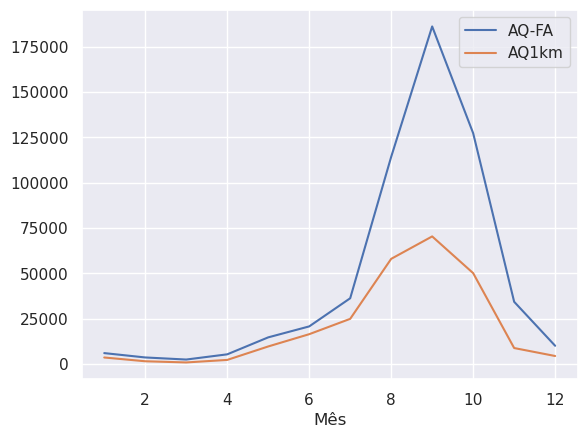

In [56]:
data_df.drop(["Ano"], axis=1).set_index(["Mês"]).plot.line()

<Axes: xlabel='Mês'>

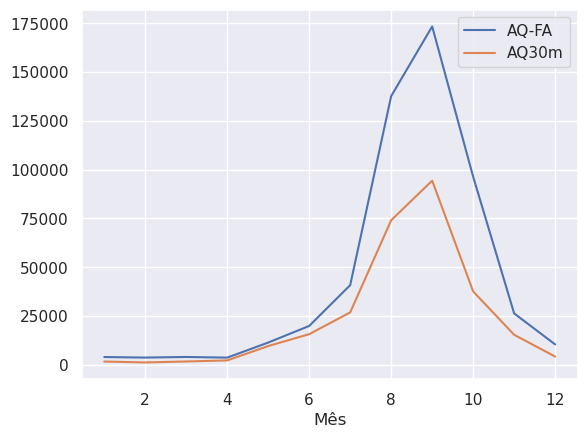

In [50]:
data_df.drop(["Ano"], axis=1).set_index(["Mês"]).plot.line()

In [17]:
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm_gdf = gpd.read_file('aq30m/LS8_AQM_221_067_20210719_0107.zip')
reference_area_km2 = aqm_gdf['km2'].sum()
aqm_gdf = normalize_gdf(aqm_gdf, geometry, quadrat_width)
explore_df = sub_space_by_landsat(df.query("'2021-07-03 14:00:00-03:00' < datahora < '2021-07-19 14:00:00-03:00'"), path, row)

explorer = SatellitesExplore(explore_df, 
                             delimited_region=geometry,
                             quadrat_width=quadrat_width, 
                             burned_area_calc=burned_area_calc,
                             min_area_percentage=min_area_percentage,
                             threshold_satellite=threshold_satellite)
xmin, ymin, xmax, ymax = geometry.bounds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
fig.tight_layout()

plot_burned_gdf(ax1, aqm_gdf, legend=False)
configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
cx.add_basemap(ax1, crs=aqm_gdf.crs.to_string())
ax1.plot(*geometry.exterior.xy)
ax1.set_title('AQ30m')
ax1.legend(title = "{:.2f}Km²".format(reference_area_km2), loc='lower left')

explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds', with_color_bar=False)
configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
ax2.plot(*geometry.exterior.xy)
ax2.set_title('AQ-FA')

fig.savefig(os.path.join(image_folder, 'validacao_221_67.pdf'), bbox_inches="tight")

HTTPError: HTTP Error 403: Forbidden

<Axes: xlabel='value', ylabel='value'>

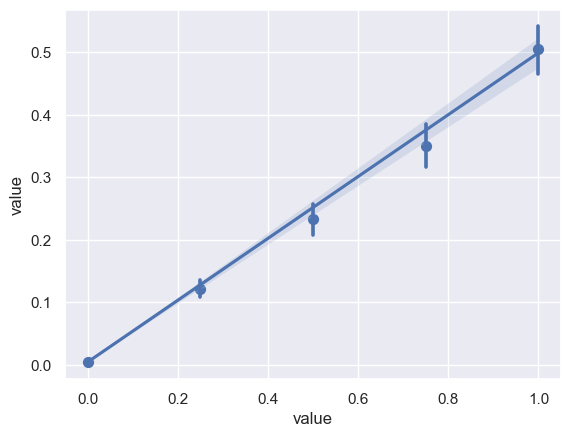

In [167]:
burned = explorer.get_burned_areas()
temp = gpd.GeoDataFrame(
    { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
    crs = burned.crs
)
ax = plt.gca()
sns.regplot(x=aqm_gdf['value'], y=temp['value'], x_bins=[0.0, 0.25, 0.50, 0.75, 1])
# sns.jointplot(x=aqm_gdf['value'], y=temp['value'], kind='reg')


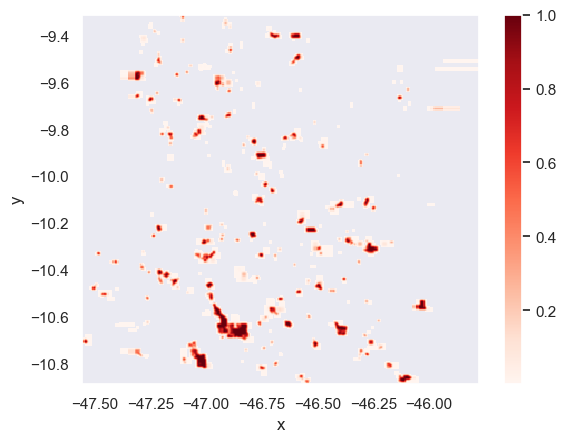

In [133]:
import cv2

temp = gpd.GeoDataFrame(
    { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
    crs = burned.crs
)
dataarray = create_dataarray(temp)
# kernel = np.array([
#     [0   ,1/16, 1/8, 1/16, 0   ],
#     [1/16, 1/8, 1/4, 1/8, 1/16],
#     [1/8 , 1/6, 1/2, 1/6, 1/8 ],
#     [1/16, 1/8, 1/6, 1/8, 1/16],
#     [0   ,1/16, 1/8,1/16, 0   ],
# ])
kernel = np.array([
    [1/16, 1/8, 1/16],
    [1/8,  1/4, 1/8],
    [1/16, 1/8, 1/16],
])
dataarray.data = np.clip(cv2.filter2D(dataarray.fillna(0.0).to_numpy(), -1, kernel), 0.0, 1.0)
dataarray.where(dataarray > 0).plot(cmap='Reds')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


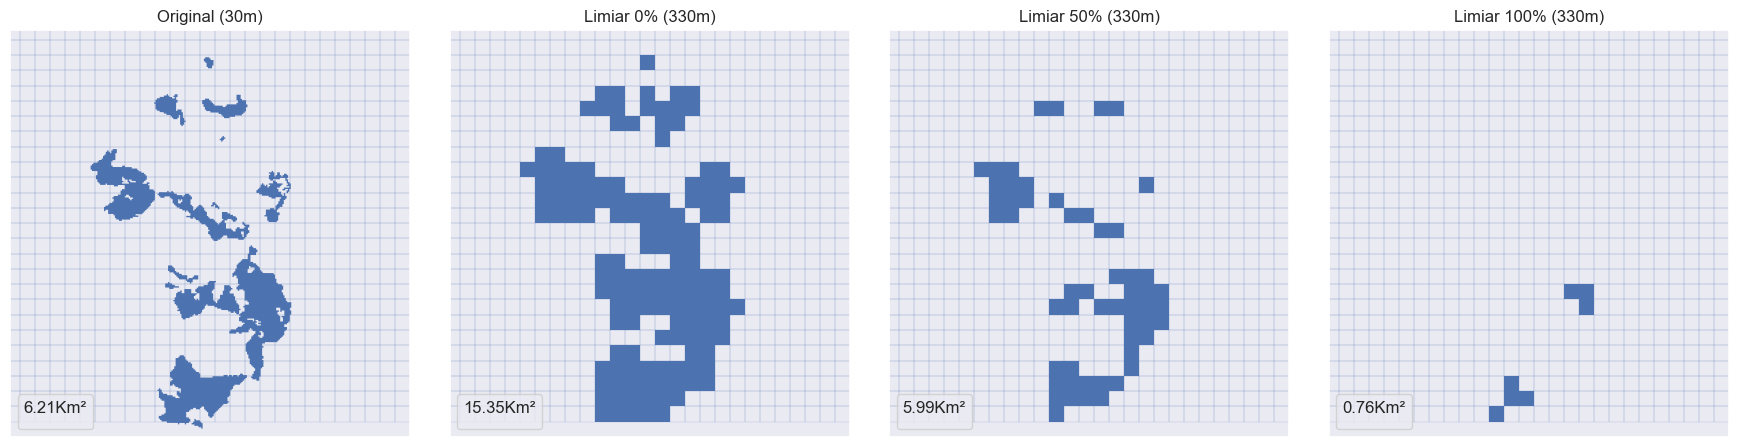

In [152]:
# cmap1 = copy.copy(plt.cm.rainbow)
quadrat_width = 0.003
linewidth = 0.1
geometry = box(-47.27, -10.77, -47.19, -10.69)
xmin, ymin, xmax, ymax = geometry.bounds
geod = Geod(ellps="WGS84")

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

threshold = [0.0, 0.5, 0.9999]

for i, t in enumerate(threshold):
    ax = axs[i+1]
    test = normalize_gdf(aqm30, geometry, quadrat_width)
    test.loc[test['value'] > t, 'value'] = 1
    test.loc[test['value'] <= t, 'value'] = 0
    plot_burned_gdf(ax, test, simple = True)
    test.boundary.plot(ax=ax, linewidth=linewidth)
    new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
    ax.set_title(f"Limiar {round(t * 100)}% ({round(new_resolution)}m)")

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'diferenca_resoluções.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


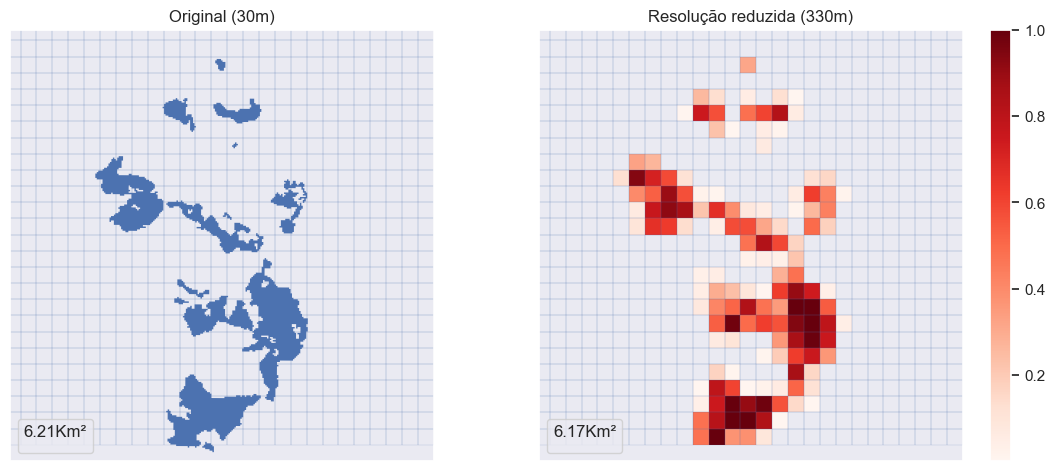

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

ax2 = axs[1]
test = normalize_gdf(aqm30, geometry, quadrat_width)
plot_burned_gdf(ax2, test)
test.boundary.plot(ax=ax2, linewidth=linewidth)
new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
ax2.set_title(f'Resolução reduzida ({round(new_resolution)}m)')

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'resolução_continua.pdf'), bbox_inches="tight")